# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the Data for ML Project

In [2]:
df=pd.read_excel('marketing_campaign.xlsx')

In [3]:
df.shape

(2240, 29)

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


# Setting Display options to ensure feature name visibility

In [5]:
pd.set_option('display.max_columns',None)

# Warning Suppression 

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Drop ID Feature from the dataset

In [7]:
df=df.drop(['ID'],axis=1)

# Defining Target and Independent Features

In [8]:
type(df['Response'])

pandas.core.series.Series

In [9]:
Y=df[['Response']]
X=df.drop(['Response'],axis=1)

# Get the Response Rate

In [10]:
Y.mean()

Response    0.149107
dtype: float64

# Build Derived Features - Customer Age and Tenure

In [ ]:
import datetime
reference_date=datetime.datetime(2021,1,1)
print(reference_date)

In [ ]:
X['Year_Birth']=pd.to_datetime(df['Year_Birth'], format='%Y')
X['Age'] = (reference_date- X['Year_Birth']).astype('timedelta64[Y]')

X['Dt_Customer']=pd.to_datetime(X['Dt_Customer'])
X['Cust_Tenure'] = (reference_date- X['Dt_Customer']).astype('timedelta64[Y]')

X=X.drop(['Year_Birth','Dt_Customer'],axis=1)

In [ ]:
X[['Age','Cust_Tenure']].head()

# Split features into Numerical and Categorical

In [ ]:
num=X.select_dtypes(include="number")
char=X.select_dtypes(include="object")

In [ ]:
def unique_levels(x):
    x=x.value_counts().count()
    return(x)
df_value_counts=pd.DataFrame(num.apply(lambda x : unique_levels(x)))

In [ ]:
df_value_counts.columns=['feature_levels']
df_value_counts.head()

In [ ]:
slice1=df_value_counts.loc[df_value_counts['feature_levels']<=20]
cat_list=slice1.index
cat=num.loc[:,cat_list]
cat.dtypes

In [ ]:
def data_type_converter(x):
    x=x.astype('object')
    return(x)
cat=cat.apply(lambda x : data_type_converter(x))
cat.dtypes

In [ ]:
slice2=df_value_counts.loc[df_value_counts['feature_levels']>20]
num_list=slice2.index
num=num.loc[:,num_list]

In [ ]:
char=pd.concat([char,cat],axis=1,join="inner")

In [ ]:
print ("The shape of numerical dataframe :",num.shape)
print ("The shape of categorical datafrme :",char.shape)

# Outlier Analysis of Numerical Features

In [ ]:
num.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.85,0.9,0.99])

# Capping and Flooring of outliers

In [ ]:
def outlier_cap(x):
    x=x.clip(lower=x.quantile(0.01))
    x=x.clip(upper=x.quantile(0.99))
    return(x)

In [ ]:
num=num.apply(lambda x : outlier_cap(x))

In [ ]:
num.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.85,0.9,0.99])

# Missing Value Handling - Numerical Features 

In [ ]:
num.isnull().mean()

# Missing Value Handling - Numerical Features (Imputation with Mean)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
num_1=pd.DataFrame(imputer.fit_transform(num),index=num.index,columns=num.columns)

In [ ]:
num_1.isnull().mean()

# Missing Value Handling - Categorical Features (Remove >25% Missing Rows)

In [ ]:
char.isnull().mean()

# Feature Selection - Numerical Features 

# Part 1 : Remove Features with 0 Variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold

varselector= VarianceThreshold(threshold=0)
varselector.fit_transform(num_1)
# Get columns to keep and create new dataframe with those only
cols = varselector.get_support(indices=True)
num_2 = num_1.iloc[:,cols]

In [ ]:
num_2.iloc[0]

# Part 2 - Bi Variate Analysis (Feature Discretization)

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
discrete=KBinsDiscretizer(n_bins=10,encode='ordinal', strategy='quantile')
num_binned=pd.DataFrame(discrete.fit_transform(num_2),index=num_2.index, columns=num_2.columns).add_suffix('_Rank')
num_binned.head()

In [ ]:
X_bin_combined=pd.concat([Y,num_binned],axis=1,join='inner')

from numpy import mean
for col in (num_binned.columns):
    plt.figure()
    sns.lineplot(x=col,y=X_bin_combined['Response'].mean(),data=X_bin_combined,color='red')
    sns.barplot(x=col, y="Response",data=X_bin_combined, estimator=mean )
plt.show()

In [ ]:
num_droplist=['Age']
num_2=num_2.drop(num_droplist,axis=1)
num_2.shape

# Part 3 - Select K Best

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2,k=6)
selector.fit_transform(num_2, Y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
select_features_df_num = num_1.iloc[:,cols]

In [ ]:
select_features_df_num.iloc[0]

# Feature Selection - Categorical Features 

In [ ]:
char.dtypes

In [ ]:
def unique_levels(x):
    x=x.value_counts().count()
    return(x)
char_unique_levels=pd.DataFrame(char.apply(lambda x : unique_levels(x)))

In [ ]:
char_unique_levels

In [ ]:
char_unique_levels.columns=['feature_levels']
slice1=char_unique_levels.loc[char_unique_levels['feature_levels']>1]
cat_list=slice1.index
char=char.loc[:,cat_list]

# Part 1 - Bi Variate Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
X_char_merged=pd.concat([Y,char],axis=1,join='inner')

from numpy import mean
for col in (char.columns):
    plt.figure()
    sns.lineplot(x=col,y=X_char_merged['Response'].mean(),data=X_char_merged,color='red')
    sns.barplot(x=col, y="Response",data=X_char_merged, estimator=mean )
plt.show()

In [ ]:
char.dtypes

In [ ]:
char_droplist=['Education','NumStorePurchases','Complain']
char=char.drop(char_droplist,axis=1)
char.shape

In [ ]:
# Create dummy features with n-1 levels
X_char_dum = pd.get_dummies(char, drop_first = True)
X_char_dum.shape

# Part 2 - Select K Best

In [ ]:
# Select K Best for Categorical Features
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=70)
selector.fit_transform(X_char_dum, Y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
select_features_df_char = X_char_dum.iloc[:,cols]

In [ ]:
select_features_df_char.dtypes

# Creating the Master Feature Set for Model Development

In [ ]:
X_all=pd.concat([select_features_df_char,select_features_df_num],axis=1,join="inner")

# Dimensionality Reduction through Variable Clustering

In [ ]:
from varclushi import VarClusHi
vc = VarClusHi(X_all,maxeigval2=1,maxclus=None)
vc.varclus()

In [ ]:
vc.info

In [ ]:
check=vc.rsquare
check

In [ ]:
filter=check[check['RS_Ratio']<=0.5]
filter.shape

In [ ]:
final_features=filter['Variable']
X_all=X_all[final_features]
X_all.shape

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_all, Y, test_size=0.3, random_state=20)

In [ ]:
print("Shape of Training Data",X_train.shape)
print("Shape of Testing Data",X_test.shape)
print("Response Rate in Training Data",y_train.mean())
print("Response Rate in Testing Data",y_test.mean())

# Building Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=20)
logreg.fit(X_train,y_train)

# Building Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(criterion='gini',random_state=20)

# Grid Search for Model Optimization

In [ ]:
# Min_Samples_Split starting from 5% of training base
from sklearn.model_selection import GridSearchCV
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [75,100,125,150] }
tree_grid = GridSearchCV(dtree, cv = 10, param_grid=param_dist,n_jobs = 3)
tree_grid.fit(X_train,y_train) 
print('Best Parameters using grid search: \n', tree_grid.best_params_)

In [ ]:
dtree=DecisionTreeClassifier(criterion='gini',random_state=20,max_depth=5,min_samples_split=75)
dtree.fit(X_train,y_train)

# Building Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(criterion='gini',random_state=20,max_depth=5,min_samples_split=75)
rf.fit(X_train,y_train)

# Building Gradient Boosting Model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbm=GradientBoostingClassifier(criterion='mse',random_state=20,max_depth=5,min_samples_split=75)
gbm.fit(X_train,y_train)

# Model Evaluation

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred_logreg=logreg.predict(X_test)
y_pred_tree=dtree.predict(X_test)
y_pred_rf=rf.predict(X_test)
y_pred_gbm=gbm.predict(X_test)

In [ ]:
print("Accuracy from Logistic Regression Model :",metrics.accuracy_score(y_test, y_pred_logreg))
print("Precision from Logistic Regression Model :",metrics.precision_score(y_test,y_pred_logreg))
print("Recall from Logistic Regression Model :",metrics.recall_score(y_test,y_pred_logreg))
print("f1_score from Logistic Regression Model :",metrics.f1_score(y_test,y_pred_logreg))
print("Area under ROC Curve from Logistic Regression Model :",metrics.roc_auc_score(y_test,y_pred_logreg))
print("Gini from the Logistic Regression Model :",2*metrics.roc_auc_score(y_test,y_pred_logreg)-1)

In [ ]:
metrics.plot_confusion_matrix(logreg,X_all,Y)

In [ ]:
print("Accuracy from Decision Tree Model :",metrics.accuracy_score(y_test, y_pred_tree))
print("Precision from Decision Tree Model :",metrics.precision_score(y_test,y_pred_tree))
print("Recall from Decision Tree Model :",metrics.recall_score(y_test,y_pred_tree))
print("f1_score from Decision Tree Model :",metrics.f1_score(y_test,y_pred_tree))
print("Area under ROC Curve from Decision Tree Model :",metrics.roc_auc_score(y_test,y_pred_tree))
print("Gini from the Decision Tree Model :",2*metrics.roc_auc_score(y_test,y_pred_tree)-1)

In [ ]:
metrics.plot_confusion_matrix(dtree,X_all,Y)

In [ ]:
print("Accuracy from Random Forest Model :",metrics.accuracy_score(y_test, y_pred_rf))
print("Precision from Random Forest Model :",metrics.precision_score(y_test,y_pred_rf))
print("Recall from Random Forest Model :",metrics.recall_score(y_test,y_pred_rf))
print("f1_score from Random Forest Model :",metrics.f1_score(y_test,y_pred_rf))
print("Area under ROC Curve from Random Forest Model :",metrics.roc_auc_score(y_test,y_pred_rf))
print("Gini from the Random Forest Model :",2*metrics.roc_auc_score(y_test,y_pred_rf)-1)

In [ ]:
metrics.plot_confusion_matrix(rf,X_all,Y)

In [ ]:
print("Accuracy from GBM Model :",metrics.accuracy_score(y_test, y_pred_gbm))
print("Precision from GBM Model :",metrics.precision_score(y_test,y_pred_gbm))
print("Recall from GBM Model :",metrics.recall_score(y_test,y_pred_gbm))
print("f1_score from GBM Model :",metrics.f1_score(y_test,y_pred_gbm))
print("Area under ROC Curve from GBM Model :",metrics.roc_auc_score(y_test,y_pred_gbm))
print("Gini from the GBM Model :",2*metrics.roc_auc_score(y_test,y_pred_gbm)-1)

In [ ]:
metrics.plot_confusion_matrix(gbm,X_all,Y)

# Extracting Feature Importance from the best model

In [ ]:
import pandas as pd
feature_importances=pd.DataFrame(gbm.feature_importances_,
                                 index=X_train.columns,
                                 columns=['importance']).sort_values('importance',ascending=False)
feature_importances.shape

# Extracting the Top 10 Important Model Features

In [ ]:
feature_importances.iloc[0:10]

# Plotting the top 10 feature importances in a Horizontal Bar Plot

In [ ]:
ax=sns.barplot(x='importance',y=feature_importances.iloc[0:10].index,data=feature_importances.iloc[0:10])

# Probability Decile Analysis and Gains Chart / Lorenz Curve

# Step 1 : Getting the Model Probabilities

In [ ]:
y_pred_prob = gbm.predict_proba(X_all)[:, 1]
df['pred_prob']=pd.DataFrame(y_pred_prob)

# Step 2 : Create Deciles based on the Model Probabilities

In [ ]:
df['P_Rank_gbm']=pd.qcut(df['pred_prob'].rank(method='first').values,10,duplicates='drop').codes+1
df[['pred_prob','P_Rank_gbm']].head()

# Step 3 : Summarize the data at Decile Level for Analysis

In [ ]:
rank_df=df.groupby('P_Rank_gbm')['Response'].agg(['count','mean']).sort_values(by='P_Rank_gbm',ascending=False)
rank_df.rename(columns={'mean':'Actual_event_rate'},inplace=True)
rank_df

# Step 4 - Event Capture Analysis across Probability Deciles

In [ ]:
rank_df['N_events']=rank_df['count']*rank_df['Actual_event_rate']
rank_df['cum_events']=rank_df['N_events'].cumsum()
rank_df['event_cap']=rank_df['N_events']/max(rank_df['N_events'].cumsum())
rank_df['cum_event_cap']=rank_df['event_cap'].cumsum()
rank_df

# Step 5 - Non Event Capture Analysis across Probability Deciles

In [ ]:
rank_df['N_non_events']=rank_df['count']-rank_df['N_events']
rank_df['cum_non_events']=rank_df['N_non_events'].cumsum()
rank_df['non_event_cap']=rank_df['N_non_events']/max(rank_df['N_non_events'].cumsum())
rank_df['cum_non_event_cap']=rank_df['non_event_cap'].cumsum()
rank_df

# Step 6 - Compute KS Statistic and Lift over Baseline Event Rate

In [ ]:
rank_df['KS']=round((rank_df['cum_event_cap']-rank_df['cum_non_event_cap']),4)
rank_df['Baseline_Event_Rate']=(max(rank_df['cum_events'])/max(rank_df['count'].cumsum()))
rank_df['Lift_over_Avg']=rank_df['Actual_event_rate']/rank_df['Baseline_Event_Rate']
rank_df

# Step 7 - Create Deciles (1-10) column to indicate the Decile number

In [ ]:
rank_df=rank_df.reset_index()
rank_df['Decile']=rank_df.index+1
rank_df

# Visualizing the performance of Model Probabilties across Deciles

# Step 8 - Create the Rank Ordering Chart

In [ ]:
ax = sns.lineplot(x="Decile", y="Actual_event_rate", data=rank_df,color='green').set_title('Rank Ordering Chart')
ax = sns.scatterplot( x="Decile", y="Baseline_Event_Rate", data=rank_df,color='red')
ax.legend(['Actual_event_rate', 'Baseline_Event_Rate'])

# Step 9 - Create the Lift Chart

In [ ]:
ax = sns.barplot( x="Decile", y="Lift_over_Avg", data=rank_df,color='blue').set_title('Lift Chart')

# Step 10 - Create the Gains Chart / Lorenz Curve

In [ ]:
ax = sns.lineplot( x="Decile", y="cum_event_cap", data=rank_df,color='red').set_title('Rank Ordering Chart')
ax = sns.lineplot( x="Decile", y="cum_non_event_cap", data=rank_df,color='green')
ax.legend(['cum_event_cap', 'cum_non_event_cap'])

# Is our Model able to Maximise Event/Non-Event Discrimination by the Top 3 deciles?

In [ ]:
ax = sns.barplot( x="Decile", y="KS", data=rank_df,color='brown')
ax.legend(['KS'])

# Utlize APT framework to build a Machine Learning Driven Strategy

# A - Audience (Who do we target?)

In [ ]:
df['Predicted_Resp_Rank']=np.where(df['P_Rank_gbm']>=9,"Top 2","Bottom 8")
df['Predicted_Resp_Rank'].value_counts()

In [ ]:
df_top2=df.loc[df['Predicted_Resp_Rank']=="Top 2",:]
df_top2.shape

# P - Prioritization (Based on Business Value and Customer Engagement)

In [ ]:
df_top2['spend_cnt']=np.count_nonzero(df_top2[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']],axis=1)
df_top2['spend_cnt'].describe()

In [ ]:
df_top2['Engagement']=np.where(df_top2['spend_cnt']<df_top2['spend_cnt'].quantile(0.75),"Low","High")
df_top2['Engagement'].value_counts()

In [ ]:
df_top2['Total_Spend']=df_top2['MntWines']+df_top2['MntFruits']+df_top2['MntMeatProducts']+df_top2['MntFishProducts']+df_top2['MntSweetProducts']+df_top2['MntGoldProds']
df_top2['Total_Spend'].describe()

In [ ]:
df_top2['spend_level']=np.where(df_top2['Total_Spend']<df_top2['Total_Spend'].quantile(0.75),"Low Spend","High Spend")
df_top2['spend_level'].value_counts()

In [ ]:
pd.crosstab(index=df_top2['spend_level'], columns=df_top2['Engagement'],values=df_top2['Response'],aggfunc='mean')

In [ ]:
pd.crosstab(index=df_top2['spend_level'], columns=df_top2['Engagement'],values=df_top2['Response'],aggfunc='count')

In [ ]:
df_priority_1=df_top2.loc[(df_top2['spend_level']=='High Spend') & (df_top2['Engagement']=='Low'),:]
df_priority_1.shape

In [ ]:
df_priority_2=df_top2.loc[(df_top2['spend_level']=='High Spend') & (df_top2['Engagement']=='High'),:]
df_priority_2.shape

In [ ]:
df_priority_3=df_top2.loc[(df_top2['spend_level']=='Low Spend') & (df_top2['Engagement']=='High'),:]
df_priority_3.shape

In [ ]:
df_priority_4=df_top2.loc[(df_top2['spend_level']=='Low Spend') & (df_top2['Engagement']=='Low'),:]
df_priority_4.shape

# T - Treatment (Identify Service/Product Preferences of each Priority Segment)

In [ ]:
spend_cat_priority1=df_priority_1[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']]

In [ ]:
spend_avg = spend_cat_priority1.mean(axis=0).sort_values(ascending=False)
spend_avg

In [ ]:
spend_cat_priority2=df_priority_2[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']]

In [ ]:
spend_avg = spend_cat_priority2.mean(axis=0).sort_values(ascending=False)
spend_avg

In [ ]:
spend_cat_priority3=df_priority_3[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']]

In [ ]:
spend_avg = spend_cat_priority3.mean(axis=0).sort_values(ascending=False)
spend_avg

In [ ]:
spend_cat_priority4=df_priority_4[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']]

In [ ]:
spend_avg = spend_cat_priority4.mean(axis=0).sort_values(ascending=False)
spend_avg

# Project Report and Actionable Insights

# Objective of the Project
Leverage the spend behavior and past campaign responses to build a response model that can
be used to devise a strategy that enhances the response rates and improves profitability of marketing campaigns

# Baseline Event Rate
The Response Rate from the data is 14.9%

# Algorithms Used :
In this project we have used Logistic Regression, Decision Trees, Random Forests and Gradient Boosting Algorithms

# Final Model Algorithm
Among the models that we tried building the GBM Algorithm performed the best in terms of F1_Score, Area under ROC Curve
and overall Model Gini

Therefore we have kept GBM as the final model algorithm

# Grid Search CV parameters
Maximum Depth of Tree - 5

Minimum Sample Size for Nodes to be Split - 75 Observations

# Model Performance Measures
Accuracy - 0.86

Precision - 0.58

Recall - 0.25

F1 Score - 0.35

AUC - 0.61

Gini - 0.22        

# Model Probability Discrimination Measures
Steady Event Rate Rank Ordering (Yes/No) - Yes

Rank Ordering Reversals in Top 3 Deciles (Yes/No) - No

Model Lift over  baseline event rate in the Top Decile - 5.8

Cumulative Event Capture in the Top 3 Deciles - 90% 

Maximum KS Statistic Value - 0.74

Does KS Statistic Maximize within Top 3 Deciles (Yes/No) - Yes 


# Top 10 drivers from the Model

Income

MntMeatProducts

AcceptedCmp3_1

MntFishProducts

MntFruits

Cust_Tenure_8.0

NumCatalogPurchases_10

Marital_Status_Together

Marital_Status_Single

Marital_Status_Married



# APT Stratgey Framework using the Model
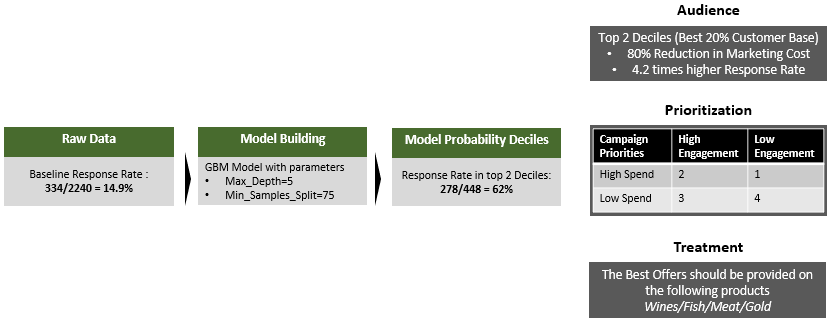